# Analyzing Patient Experience Data

In this excercise, we will analyze the patient experience data collected from the Manipal Hospitals, which is the oldest medical care group in India. In 2017, they served approx. 2 million clients from India and abroad. They have more than 5 200 beds across 16 hospitals.

Using this data we will try to find opportunities that Ajay Bakshi, MD and CEO of Manipial Hospitals, can leverage to improve the patient experience of Manipal Hospitals.

The data can be downloaded from the [Predicting NPS to Improve Patient Experience](https://www.kaggle.com/c/puj-1910-predicting/overview) kaggle competition. 

In [43]:
%load_ext autoreload
%autoreload 1

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import numpy as np
from relativeImp import relativeImp
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import shap

mpl.rcParams["font.size"] = 15

%matplotlib inline
%aimport common

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
training_data = pd.read_csv("../data/Training Data.csv")

In [46]:
column_es_en_mapping = {
    'CONSECUTIVO': "SurveyID",
    'ID': "PatientID",
    'ESTADOCIVIL': "PatientCivilStatus",
    'EDAD': "PatientAge",
    'GENERO': "PatientGender",
    'CATEGORIACAMA': "HospitalizationType",
    'DEPARTAMENTO': "Department",
    'COSTOESTIMADO': "AverageHospializationCost",
    'CATEGORIA': "AffiliationType",
    'ESTADO': "State",
    'PAIS': "Country", 
    'ZONA': "Zone", 
    'FECHAENTRADA': "PatientAdmissionDate",
    'FECHASALIDA': "PatientExitDate",
    'DIASINTERNADO': "HospitalizationDays",
    'SCORENPS': "LTR",    
}
training_data.rename(columns=column_es_en_mapping, inplace=True)

Columns meaning
```
CONSECUTIVE -> Survey identification number.
ID -> Patient identification number.
ESTADOCIVIL -> Civil status of the patient.
AGE -> Age of the patient.
GENDER -> "Sexual" identity of the user (Female or Male).
CATEGORYACAMA -> Type of hospitalization (General, Special, Intensive Care, among others).
DEPARTMENT -> Specialty for which the patient was treated (Pediatrics, Gynecology, Geriatrics, among others).
ESTIMATED COST -> Average cost of hospitalization.
CATEGORY -> Type of affiliation depending on who assumes the costs (Patient, Insurance, Corporate, among others).
STATE -> State of the country where the patient was treated.
COUNTRY -> Country where the patient was treated.
ZONE -> Zone of the country where the patient was treated.
CE_ACCESSIBILITY -> Customer Engagement - Accessibility.
CE_CSAT -> Customer Engagement - Satisfaction.
CE_VALUEFORMONEY -> Customer Engagement - Price-Quality Ratio.
EM_IMMEDIATEATTENTION -> Emergency - Immediate attention.
EM_NURSING -> Emergency - Nursing care.
EM_DOCTOR -> Emergency - Doctors care.
EM_OVERALL -> Emergency - Services in general.
AD_TIME -> Admission Process - Duration of the admission.
AD_TARRIFFPACKAGESEXPLAINATION -> Admission Process - Explanation of available rates and packages.
AD_STAFFATTITUDE -> Admission Process - Staff attitude.
INR_ROOMCLEANLINESS -> In Room Experience - Room cleaning.
INR_ROOMPEACE -> In Room Experience - Peace of mind in the room.
INR_ROOMEQUIPMENT -> In Room Experience - Room equipment.
INR_ROOMAMBIENCE -> In Room Experience - Room environment.
FNB_FOODQUALITY -> Food and Beverage - Quality.
FNB_FOODDELIVERYTIME -> Food and Beverage - Delivery time.
FNB_DIETICIAN -> Food and Beverage - Regular nutritionist advice.
FNB_STAFFATTITUDE -> Food and Beverage - Staff attitude.
AE_ATTENDEECARE -> Attendees Experience - Care during the stay.
AE_PATIENTSTATUSINFO -> Attendees Experience - Information on the patient's health status.
AE_ATTENDEEFOOD -> Attendees Experience - Variety of meals during the stay.
DOC_TREATMENTEXPLAINATION -> Doctors Experience - Treatment explanation.
DOC_ATTITUDE -> Doctors Experience - Attitude of the staff.
DOC_VISITS -> Doctors Experience - Regular visits.
DOC_TREATMENTEFFECTIVENESS -> Doctors Experience - Treatment effectiveness.
NS_CALLBELLRESPONSE -> Nursing Services - Prompt response when called.
NS_NURSESATTITUDE -> Nursing Services - Staff attitude.
NS_NURSEPROACTIVENESS -> Nursing Services - Staff proactivity.
NS_NURSEPATIENCE -> Nursing Services - Staff patience.
OVS_OVERALLSTAFFATTITUDE -> Overall Staff - Attitude of the staff in general.
OVS_OVERALLSTAFFPROMPTNESS -> Overall Staff - Readiness of the staff in general.
OVS_SECURITYATTITUDE -> Overall Staff - Attitude of the security staff.
DP_DISCHARGETIME -> Discharge Process - Duration of the output process.
DP_DISCHARGEQUERIES -> Discharge Process - Response to concerns.
DP_DISCHARGEPROCESS -> Discharge Process - General output process.
ENTRY DATE -> Patient's hospital admission date.
EXIT DATE -> Patient's date of departure from the hospital.
INTERNAL DAY -> Days of hospitalization of the patient.
SCORENPS -> NPS rated from 0 to 10.
NPS -> Classification of patients into promoters, passives and detractors.
```

It's always good to take a look at a correlation matrix of variables.

In [59]:
training_data.shape

(4989, 52)

In [58]:
training_data.head(10)

,SurveyID,PatientID,PatientCivilStatus,PatientAge,PatientGender,HospitalizationType,Department,AverageHospializationCost,AffiliationType,State,Country,Zone,CE_ACCESSIBILITY,CE_CSAT,CE_VALUEFORMONEY,EM_IMMEDIATEATTENTION,EM_NURSING,EM_DOCTOR,EM_OVERALL,AD_TIME,AD_TARRIFFPACKAGESEXPLAINATION,AD_STAFFATTITUDE,INR_ROOMCLEANLINESS,INR_ROOMPEACE,INR_ROOMEQUIPMENT,INR_ROOMAMBIENCE,FNB_FOODQUALITY,FNB_FOODDELIVERYTIME,FNB_DIETICIAN,FNB_STAFFATTITUDE,AE_ATTENDEECARE,AE_PATIENTSTATUSINFO,AE_ATTENDEEFOOD,DOC_TREATMENTEXPLAINATION,DOC_ATTITUDE,DOC_VISITS,DOC_TREATMENTEFFECTIVENESS,NS_CALLBELLRESPONSE,NS_NURSESATTITUDE,NS_NURSEPROACTIVENESS,NS_NURSEPATIENCE,OVS_OVERALLSTAFFATTITUDE,OVS_OVERALLSTAFFPROMPTNESS,OVS_SECURITYATTITUDE,DP_DISCHARGETIME,DP_DISCHARGEQUERIES,DP_DISCHARGEPROCESS,PatientAdmissionDate,PatientExitDate,HospitalizationDays,LTR,NPS
0,1,35236,Single,4.0,F,SPECIAL,PEDIATRIC,25000.0,PATIENT,Karnataka,INDIA,SOUTH,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,4,2,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2014-07-18,2014-07-21,3,9,Promotor
1,2,35237,Single,13.0,F,SPECIAL,PEDIATRIC,15000.0,PATIENT,Karnataka,INDIA,SOUTH,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2014-07-11,2014-07-16,5,10,Promotor
2,3,35234,Married,33.0,F,SEMISPECIAL,GYNAEC,70000.0,EXEMPTION,Karnataka,INDIA,SOUTH,3,2,2,4,4,4,4,3,3,4,3,3,3,3,2,3,3,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,3,4,3,2014-06-17,2014-07-20,33,7,Passive
3,4,35232,Married,51.0,F,SPECIAL,GYNAEC,150000.0,PATIENT,West Bengal,INDIA,EAST,4,4,3,4,4,4,4,4,4,4,3,4,4,3,3,4,4,4,3,4,3,4,4,4,4,4,4,3,4,4,3,3,3,4,3,2014-07-16,2014-07-22,6,10,Promotor
4,5,35233,Married,31.0,F,SPECIAL,GYNAEC,100000.0,INSURANCE,Karnataka,INDIA,SOUTH,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2014-07-13,2014-07-16,3,10,Promotor
5,6,35230,Single,0.5,F,SEMISPECIAL,PEDIATRIC,15000.0,EXEMPTION,Karnataka,INDIA,SOUTH,4,3,3,4,4,4,4,4,4,4,4,4,4,4,3,4,4,4,4,4,4,4,4,4,4,3,4,3,4,4,4,4,4,4,4,2014-07-15,2014-07-18,3,10,Promotor
6,7,35231,Single,7.0,F,SPECIAL,PEDIATRIC,50000.0,PATIENT,Karnataka,INDIA,SOUTH,3,3,4,4,4,4,3,1,2,2,3,4,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,3,3,3,3,3,4,2014-07-17,2014-07-23,6,10,Promotor
7,8,73391,Single,22.0,F,GENERAL,GEN,40000.0,INSURANCE,Karnataka,INDIA,SOUTH,4,3,3,4,4,4,4,3,3,4,3,3,3,3,2,3,3,4,3,3,2,4,4,4,4,4,4,4,4,4,4,4,3,4,3,2014-09-15,2014-09-20,5,9,Promotor
8,9,73462,Married,65.0,M,SPECIAL,RENAL,150000.0,INSURANCE,Karnataka,INDIA,SOUTH,4,4,4,4,4,4,4,4,4,4,4,4,4,3,2,3,3,3,3,3,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2014-09-16,2014-09-20,4,9,Promotor
9,10,35238,Single,15.0,F,SEMISPECIAL,PEDIATRIC,20000.0,PATIENT,Karnataka,INDIA,SOUTH,4,4,3,3,4,4,4,4,4,4,3,3,4,4,3,4,4,4,4,4,3,4,4,3,4,4,4,3,4,4,4,4,2,3,2,2014-07-12,2014-07-16,4,10,Promotor


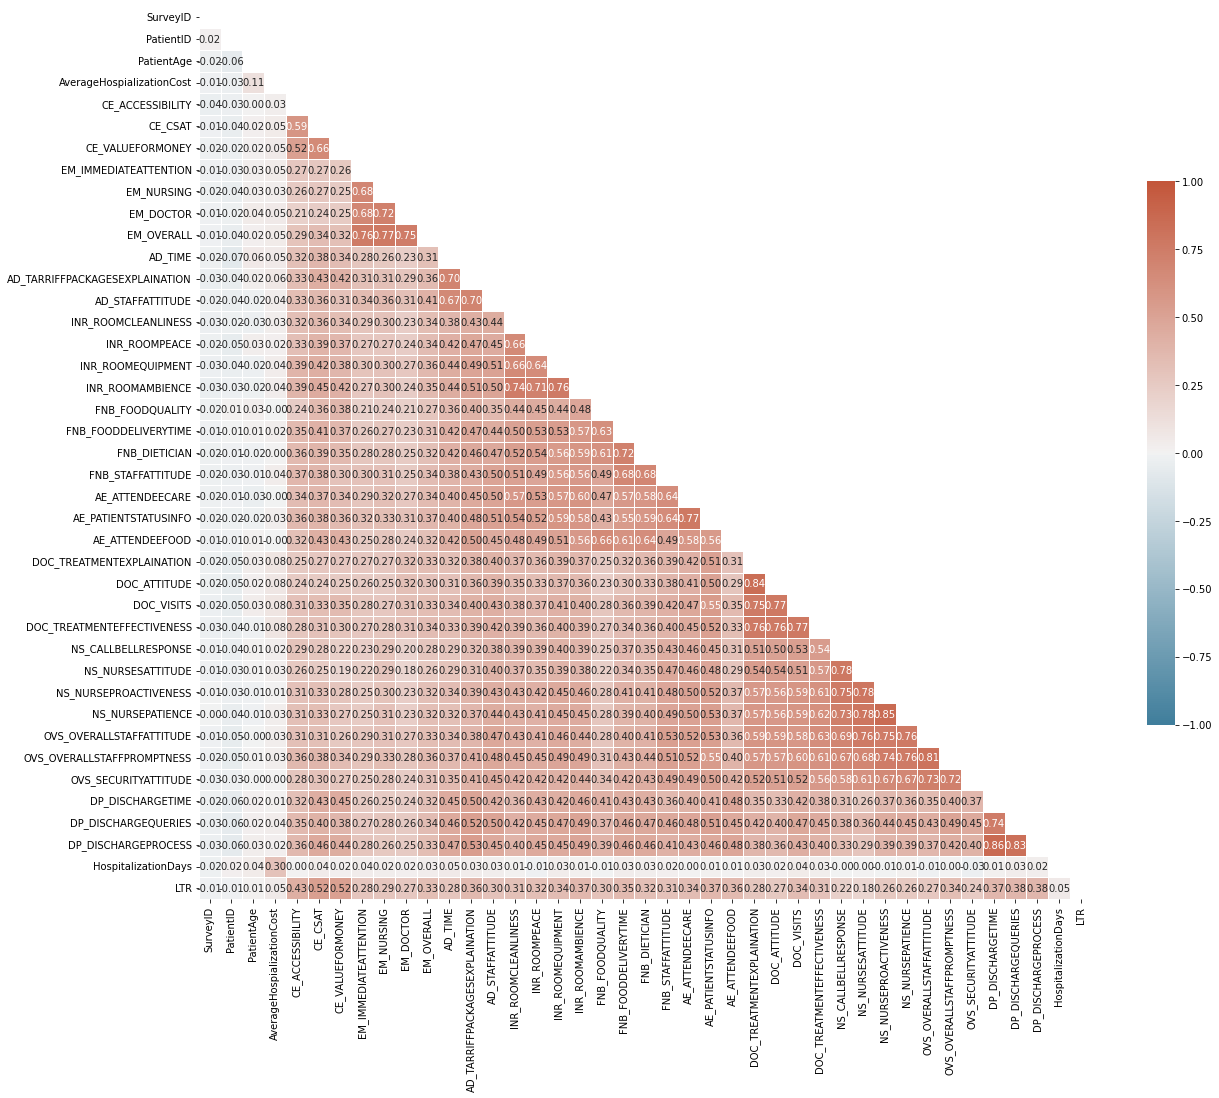

In [4]:
corr_matrix = training_data.select_dtypes(include=['float64', "int64"]).corr()
common.vis_correlation_matrix(corr_matrix, figsize=(20, 20))

The patient satisfaction data measures the following dimensions:
- customer engagement (prefix CE_)
- Emergency (EM_)
- Admission process (AD_)
- In room experience (INR_)
- Food and beverage (FNB_)
- Attendees experience (AE_)
- Doctors experience (DOC_)
- Nursing services (NS_)
- Overall staff (OVS_)
- Discharge process (DP_)

Let's start by computing dimension-level scores and comparing them to see which of the dimensions scored the lowest.

In [60]:
dimension_prefix_mapping = {
    #"Customer Engagement": "CE_",
    "Admission Process": "AD_",
    "In Room Experience": "INR_",
    "Food and Beverage": "FNB_",
    "Attendees Experience": "AE_",
    "Doctors Experience": "DOC_",
    "Nursing Services": "NS_",
    "Overall Staff": "OVS_",
    "Discharge Process": "DP_"
}

series = []
for dimension_name, prefix in dimension_prefix_mapping.items():
    series.append(training_data.loc[:, training_data.columns.str.startswith(prefix)].mean(axis=1).rename(dimension_name))
dimension_level_data = pd.concat(series, axis=1)

In [61]:
dimension_level_data.head()

,Admission Process,In Room Experience,Food and Beverage,Attendees Experience,Doctors Experience,Nursing Services,Overall Staff,Discharge Process
0,4.000000,4.0,3.00,3.666667,4.0,4.00,4.000000,4.000000
1,4.000000,4.0,4.00,4.000000,4.0,4.00,4.000000,4.000000
2,3.333333,3.0,3.00,3.666667,4.0,4.00,4.000000,3.333333
3,4.000000,3.5,3.75,3.333333,4.0,3.75,3.333333,3.333333
4,4.000000,4.0,4.00,4.000000,4.0,4.00,4.000000,4.000000


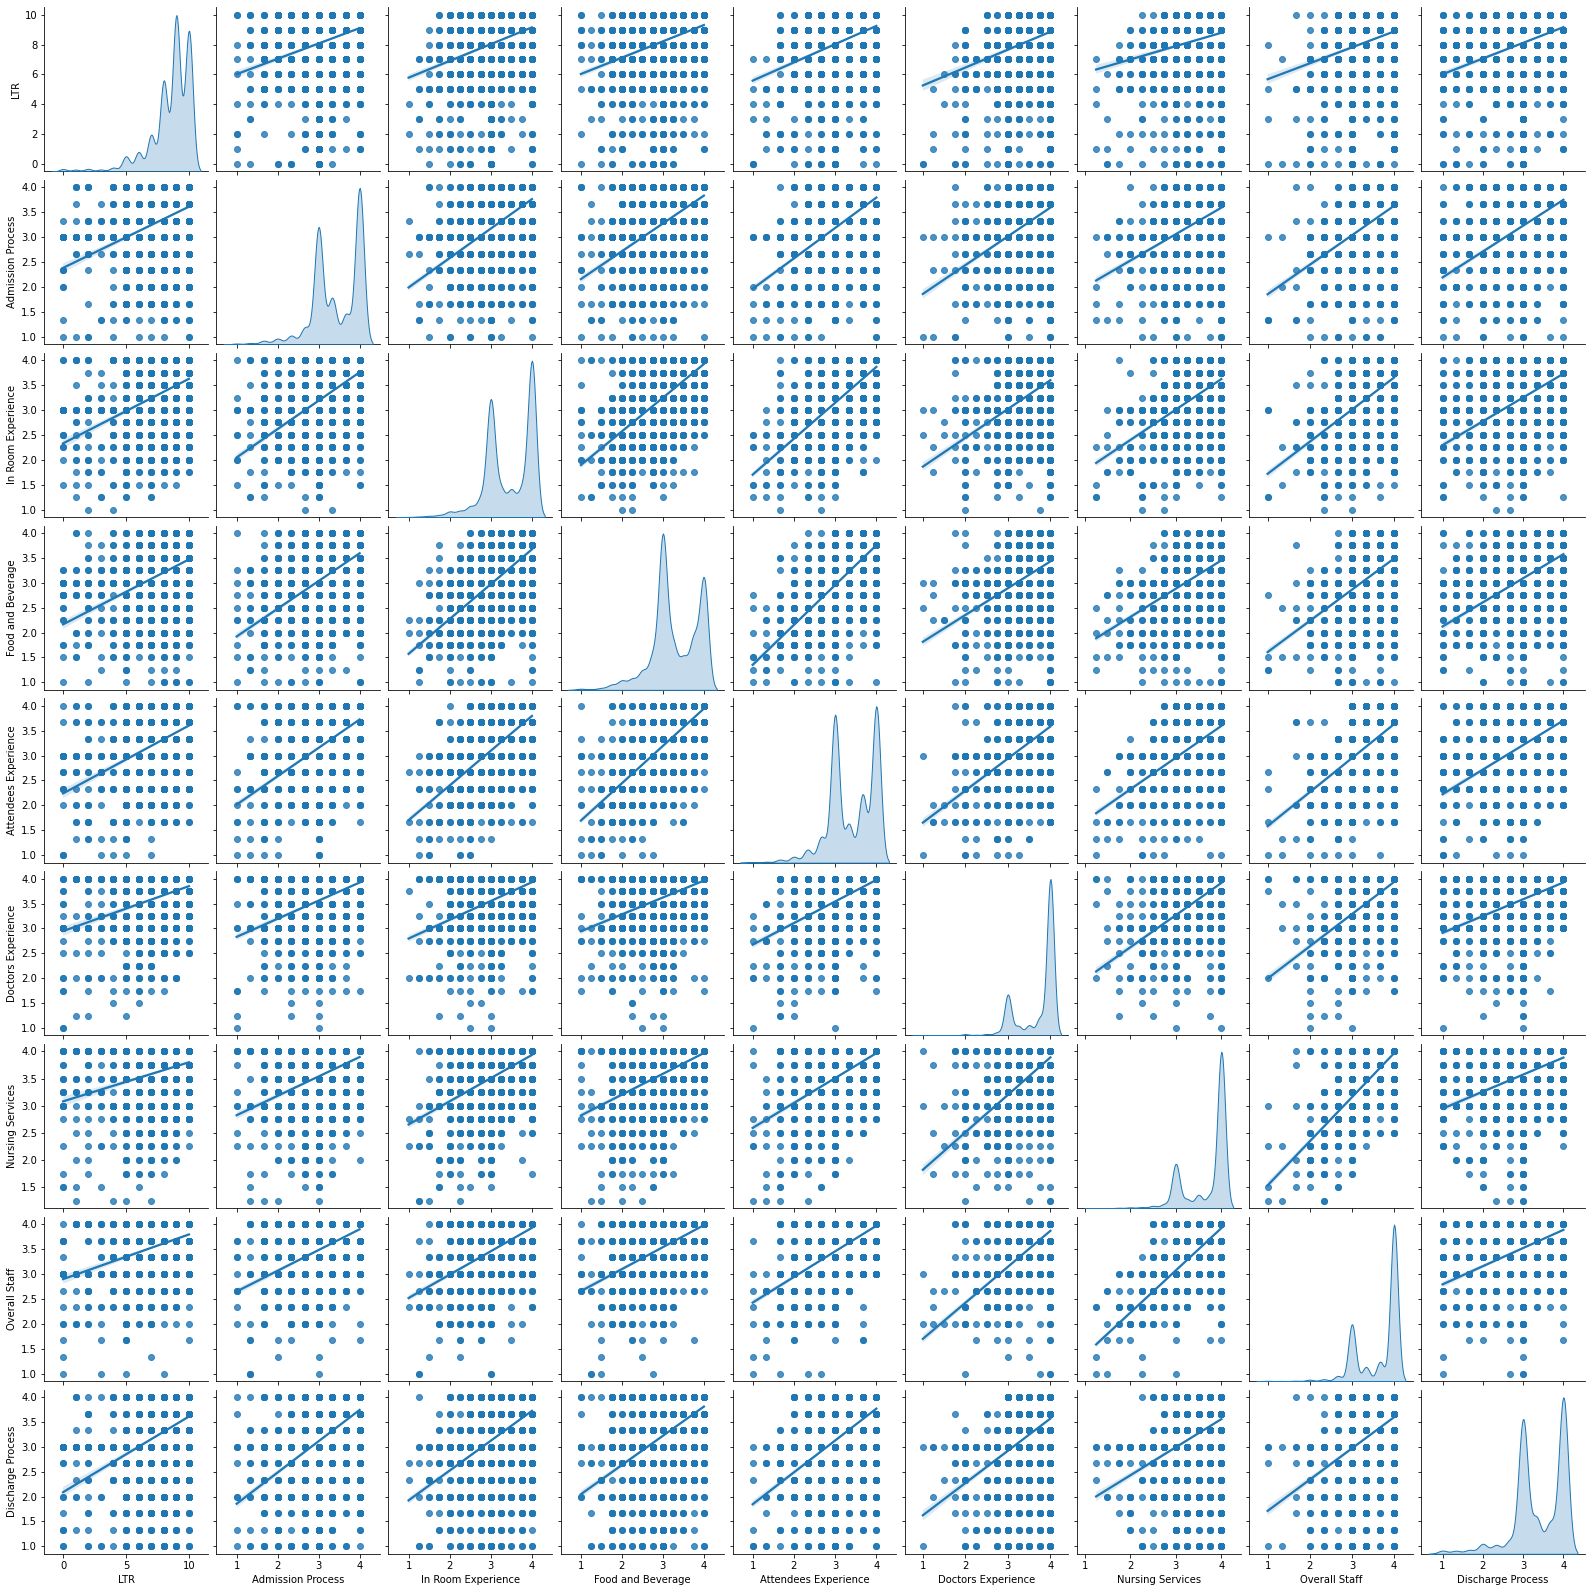

In [7]:
plot_data = dimension_level_data.copy()
plot_data.insert(0, "LTR", training_data["LTR"])
_ = sns.pairplot(plot_data, kind="reg", diag_kind="kde")

## Q1: Which dimension scored the lowest?

In [8]:
dimension_level_data.mean().sort_values(ascending=True)

Food and Beverage       3.276458
Discharge Process       3.382174
Attendees Experience    3.401283
Admission Process       3.431015
In Room Experience      3.434305
Overall Staff           3.660787
Nursing Services        3.692924
Doctors Experience      3.714472
dtype: float64

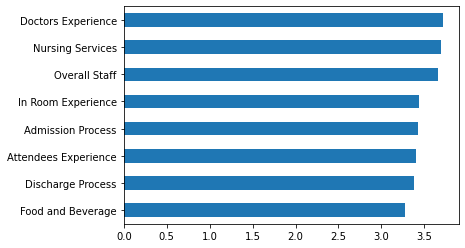

In [49]:
dimension_level_data.mean().sort_values().plot(kind="barh");

From the above we might conclude that one needs to improve the experience in the `Food and Beverage` and the `Discharge Process` first, as these dimensions scored the lowest.

## Q2: Can we predict the LTR score based on the patient satisfaction data?

In [62]:
training_data["LTR"].mean()

8.514131088394468

In [10]:
X = dimension_level_data
y = training_data["LTR"]
cv_splits = 10
scoring = "neg_root_mean_squared_error"

scores = np.abs(cross_val_score(DummyRegressor(), X, y, cv=cv_splits, scoring=scoring))
print(f"Dummy Regressor: {scores.mean():.2f} +/- {scores.std():.2f}")

scores = np.abs(cross_val_score(LinearRegression(), X, y, cv=cv_splits, scoring=scoring))
print(f"Linear Regression: {scores.mean():.2f} +/- {scores.std():.2f}")

param_grid = {
    "min_samples_leaf": [5, 10, 20],
    "criterion": ["squared_error", "absolute_error", "poisson"]
}

clf = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=cv_splits, scoring=scoring, n_jobs=-1)
clf.fit(X, y)
cv_results = pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score")
print(f"Random Forest: {np.abs(cv_results.iloc[0].mean_test_score):.2f} +/- {cv_results.iloc[0].std_test_score:.2f}")

Dummy Regressor: 1.66 +/- 0.07
Linear Regression: 1.46 +/- 0.06
Random Forest: 1.37 +/- 0.04


## Multiple Linear Regression
$\textrm{LTR} = \alpha_1 \textrm{FoodAndBeverage} + \alpha_2\textrm{Discharge Experience} + \alpha_3 \textrm{Attendees Experience} \ldots$

R2 = 0.23


Nursing Services       -0.391877
Overall Staff           0.136252
Admission Process       0.170595
Food and Beverage       0.186000
In Room Experience      0.274068
Attendees Experience    0.375403
Doctors Experience      0.466034
Discharge Process       0.471040
dtype: float64

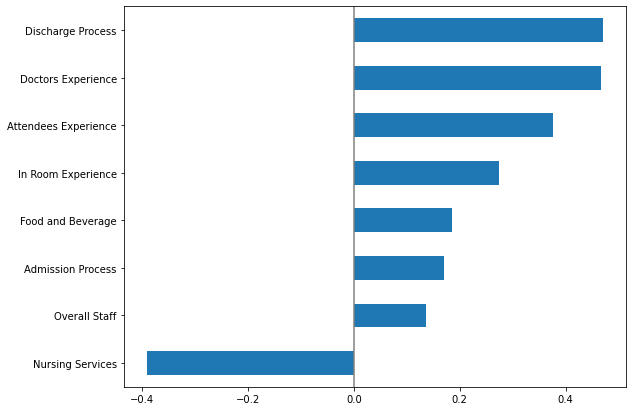

In [11]:
reg = LinearRegression().fit(dimension_level_data, training_data["LTR"])
r2 = reg.score(dimension_level_data, training_data["LTR"])
print(f"R2 = {r2:.2f}")
reg_coefs = pd.Series(reg.coef_ , index=dimension_level_data.columns).sort_values()
display(reg_coefs)
reg_coefs.plot(kind="barh", figsize=(9,7))
plt.axvline(x=0, color=".5");

The interpretation of the above linear regression coefficients is the following.
Increase in the mean Food and Beverage of 1 point results in an LTR increase of 0.186 points.

Obviously, we have a problem with this model, as the Nursing Services dimension has a negative coefficient!

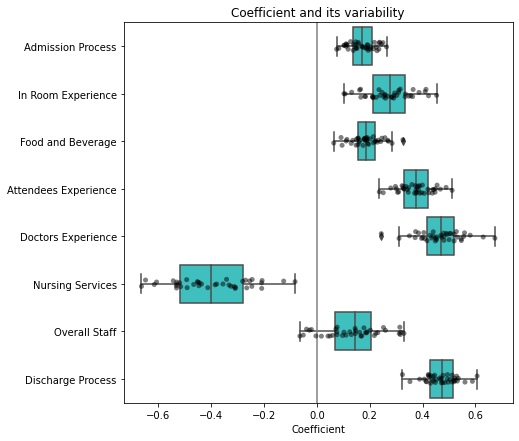

In [12]:
cv_model = cross_validate(LinearRegression(), dimension_level_data, training_data["LTR"],
    cv=RepeatedKFold(n_splits=2, n_repeats=20), return_estimator=True,n_jobs=-1)
coefs = pd.DataFrame([est.coef_ for est in cv_model["estimator"]],columns=dimension_level_data.columns)
plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient")
plt.title("Coefficient and its variability")
plt.subplots_adjust(left=0.3)

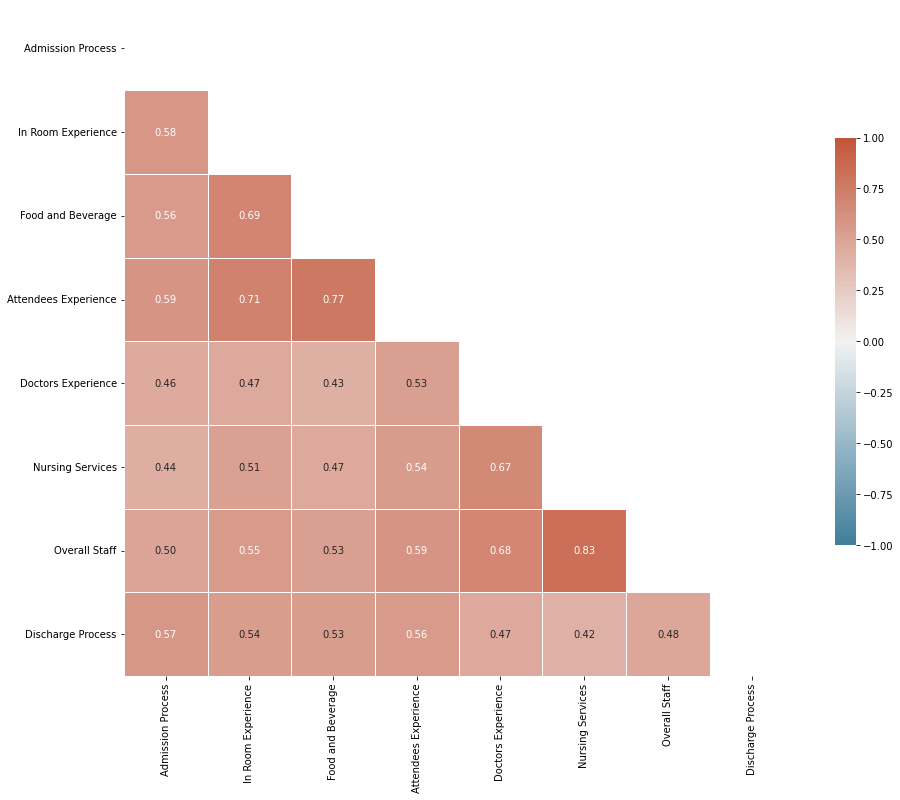

In [13]:
common.vis_correlation_matrix(dimension_level_data.corr(), figsize=(15, 15))

In [14]:
reg_explainer = shap.Explainer(reg.predict, dimension_level_data)
reg_shap_values = reg_explainer(dimension_level_data)

Exact explainer: 4990it [00:33, 116.30it/s]                                                                             


In [15]:
sample_index = 10
dimension_level_data.iloc[sample_index]

Admission Process       3.333333
In Room Experience      4.000000
Food and Beverage       3.500000
Attendees Experience    3.666667
Doctors Experience      4.000000
Nursing Services        4.000000
Overall Staff           4.000000
Discharge Process       3.333333
Name: 10, dtype: float64

In [67]:
training_data.iloc[sample_index].LTR

7

In [16]:
reg.predict(dimension_level_data.iloc[sample_index:sample_index+1])

array([8.8296532])

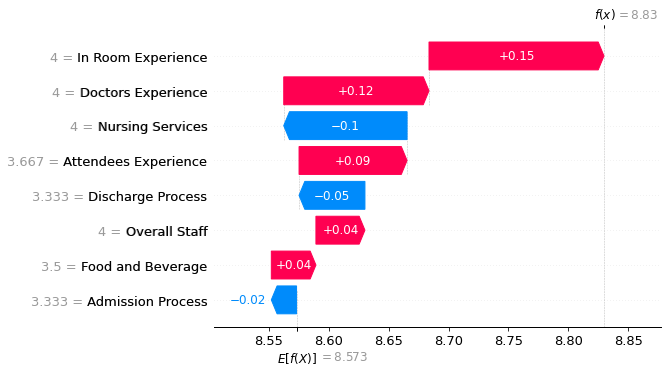

In [17]:
shap.plots.waterfall(reg_shap_values[sample_index])

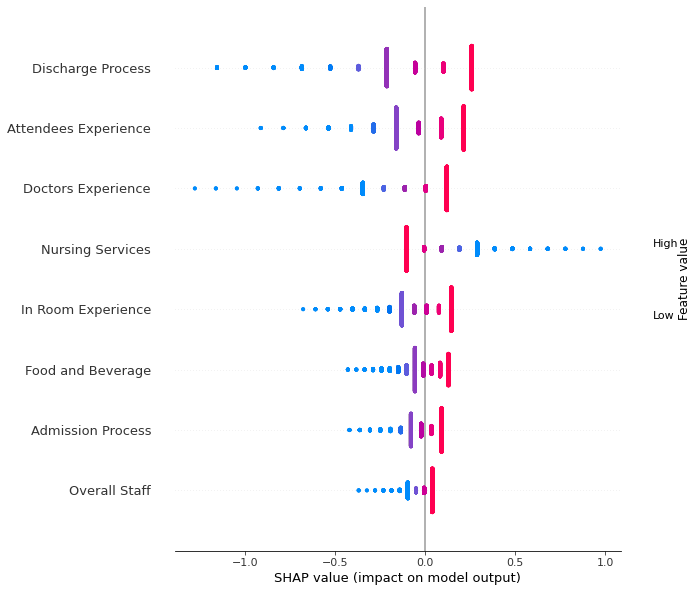

In [18]:
shap.plots.beeswarm(reg_shap_values, plot_size=(10, 10))

# Q3: Which dimension is the most important?

In [68]:
dimension_level_data.std()

Admission Process       0.575293
In Room Experience      0.564931
Food and Beverage       0.574385
Attendees Experience    0.555678
Doctors Experience      0.456155
Nursing Services        0.471296
Overall Staff           0.482253
Discharge Process       0.632334
dtype: float64

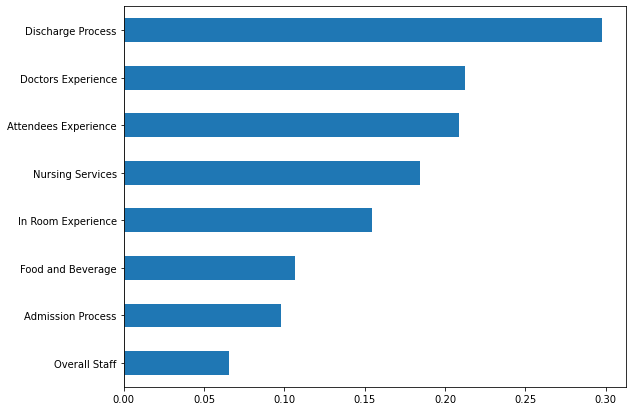

In [19]:
importance = pd.Series(reg.coef_ * dimension_level_data.std() , index=dimension_level_data.columns)
importance.abs().sort_values().plot(kind="barh", figsize=(9,7))
plt.axvline(x=0, color=".5")

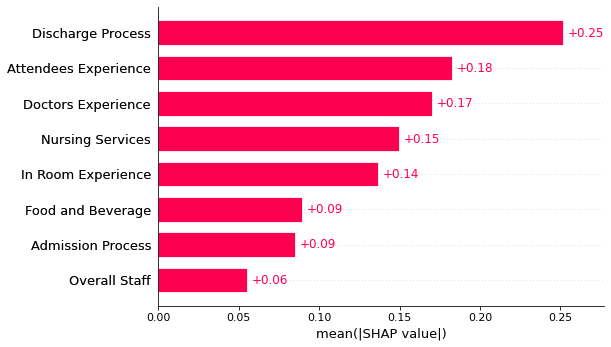

In [20]:
shap.plots.bar(reg_shap_values)

**Johnson's Relative Weights**

*Johnson JW. A heuristic method for estimating the relative weight of predictor variables in multiple regression. Multivariate behavioral research.* 2000 Jan 1;35(1):1-9. [PDF](https://d1wqtxts1xzle7.cloudfront.net/48799577/A_heuristic_method_for_estimating_the_re20160913-27311-903yb1-with-cover-page-v2.pdf?Expires=1638541980&Signature=CL5lXIPTKWbor3E7y-SD6kJguUx22eILQOrhXOatHjpSAkQnXJFWSJt1Ro5CDzPLxarO7AXO1MHVuXf2ZBrknqEGqixoMbSlikR3QOqzoqpGo8WzSSCP0Svi2WbIWILNWQMPtaYLIO7QoNLFfmSa8-9fjNBkh4Lyz0fMe5kaVe~bY0BtyF5eKlCI69VexqAqKnYWMxGUEeeM8HNvAADKjmxMMkUcnP6q1poOx-JtkrhOnwwk4Rdbz4OCQsfZ2ulMJA-et6Yic1AD5WrZZbwioieStQPDfe1jC0f~lf8tY8YN4fcusSSmoDtBdA8dLUBFyTqdL9GpnMRMmHmUdBIy6w__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)

In [69]:
df = dimension_level_data.copy()
df["LTR"] = training_data["LTR"]
relativeImp(df, outcomeName="LTR", driverNames=dimension_level_data.columns.to_list()).sort_values(by="normRelaImpt", ascending=False)

,driver,rawRelaImpt,normRelaImpt
7,Discharge Process,0.050440,21.962040
3,Attendees Experience,0.037053,16.133110
1,In Room Experience,0.032333,14.078213
2,Food and Beverage,0.030893,13.451148
0,Admission Process,0.028021,12.200618
4,Doctors Experience,0.026903,11.713992
6,Overall Staff,0.015367,6.690782
5,Nursing Services,0.008659,3.770097


## Q4: What the Random Forest model tells us about the data?

In [22]:
rf_explainer = shap.Explainer(clf.best_estimator_.predict, dimension_level_data)
rf_shap_values = rf_explainer(dimension_level_data)

Exact explainer: 4990it [07:18, 11.18it/s]                                                                              


In [70]:
training_data.iloc[sample_index].LTR

7

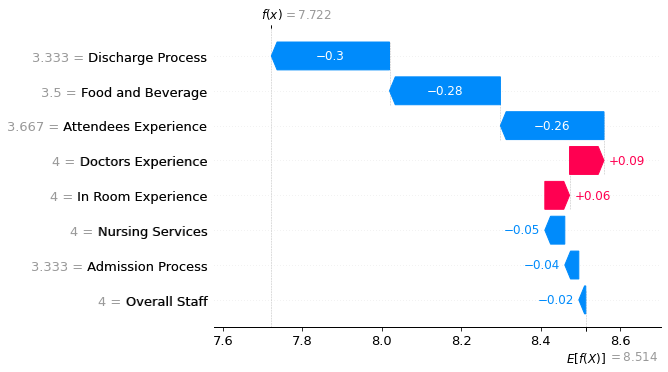

In [23]:
shap.plots.waterfall(rf_shap_values[sample_index])

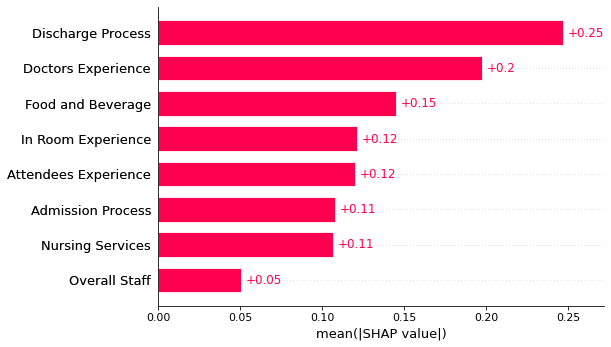

In [24]:
shap.plots.bar(rf_shap_values)

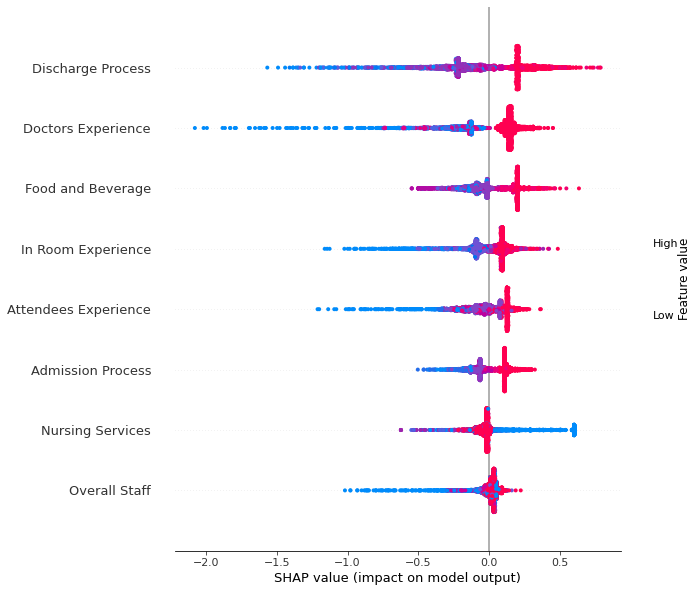

In [25]:
shap.plots.beeswarm(rf_shap_values, plot_size=(10, 10))

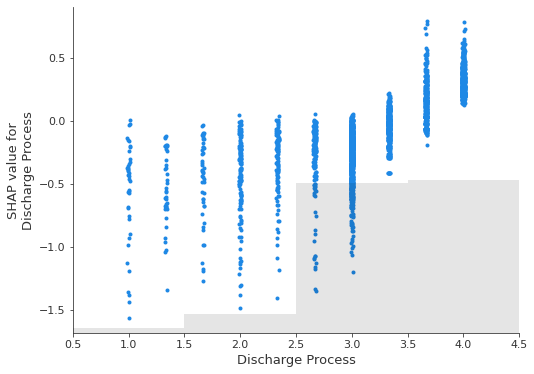

In [26]:
fig = plt.figure(figsize=(8, 6))
shap.plots.scatter(rf_shap_values[:,"Discharge Process"], ax=fig.gca())

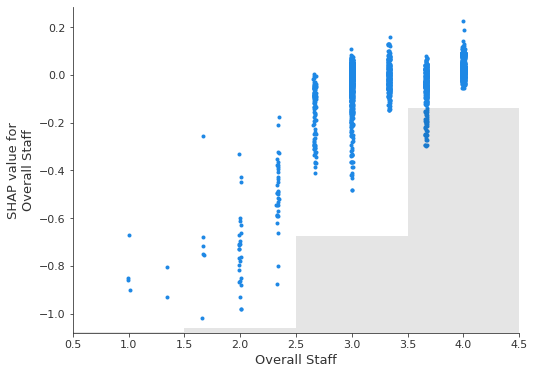

In [27]:
fig = plt.figure(figsize=(8, 6))
shap.plots.scatter(rf_shap_values[:,"Overall Staff"], ax=fig.gca())

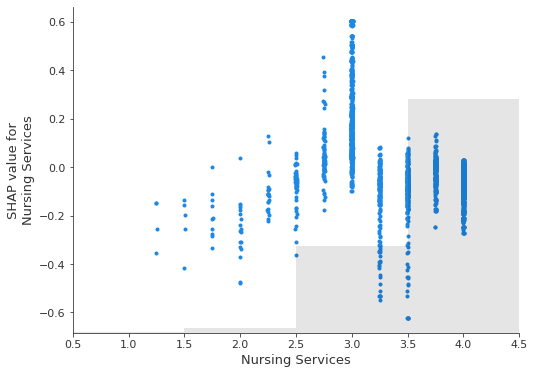

In [28]:
fig = plt.figure(figsize=(8, 6))
shap.plots.scatter(rf_shap_values[:,"Nursing Services"], ax=fig.gca())

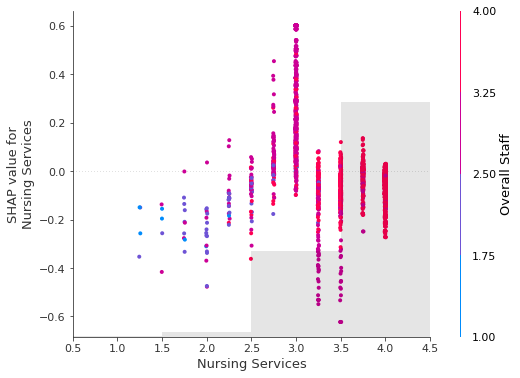

In [29]:
fig = plt.figure(figsize=(8, 6))
shap.plots.scatter(rf_shap_values[:,"Nursing Services"], color=rf_shap_values[:,"Overall Staff"], ax=fig.gca())

# Q5: Can we find any interesting segments in the data?

In [30]:
training_data.head()

,SurveyID,PatientID,PatientCivilStatus,PatientAge,PatientGender,HospitalizationType,Department,AverageHospializationCost,AffiliationType,State,Country,Zone,CE_ACCESSIBILITY,CE_CSAT,CE_VALUEFORMONEY,EM_IMMEDIATEATTENTION,EM_NURSING,EM_DOCTOR,EM_OVERALL,AD_TIME,AD_TARRIFFPACKAGESEXPLAINATION,AD_STAFFATTITUDE,INR_ROOMCLEANLINESS,INR_ROOMPEACE,INR_ROOMEQUIPMENT,INR_ROOMAMBIENCE,FNB_FOODQUALITY,FNB_FOODDELIVERYTIME,FNB_DIETICIAN,FNB_STAFFATTITUDE,AE_ATTENDEECARE,AE_PATIENTSTATUSINFO,AE_ATTENDEEFOOD,DOC_TREATMENTEXPLAINATION,DOC_ATTITUDE,DOC_VISITS,DOC_TREATMENTEFFECTIVENESS,NS_CALLBELLRESPONSE,NS_NURSESATTITUDE,NS_NURSEPROACTIVENESS,NS_NURSEPATIENCE,OVS_OVERALLSTAFFATTITUDE,OVS_OVERALLSTAFFPROMPTNESS,OVS_SECURITYATTITUDE,DP_DISCHARGETIME,DP_DISCHARGEQUERIES,DP_DISCHARGEPROCESS,PatientAdmissionDate,PatientExitDate,HospitalizationDays,LTR,NPS
0,1,35236,Single,4.0,F,SPECIAL,PEDIATRIC,25000.0,PATIENT,Karnataka,INDIA,SOUTH,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2,4,2,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2014-07-18,2014-07-21,3,9,Promotor
1,2,35237,Single,13.0,F,SPECIAL,PEDIATRIC,15000.0,PATIENT,Karnataka,INDIA,SOUTH,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2014-07-11,2014-07-16,5,10,Promotor
2,3,35234,Married,33.0,F,SEMISPECIAL,GYNAEC,70000.0,EXEMPTION,Karnataka,INDIA,SOUTH,3,2,2,4,4,4,4,3,3,4,3,3,3,3,2,3,3,4,4,4,3,4,4,4,4,4,4,4,4,4,4,4,3,4,3,2014-06-17,2014-07-20,33,7,Passive
3,4,35232,Married,51.0,F,SPECIAL,GYNAEC,150000.0,PATIENT,West Bengal,INDIA,EAST,4,4,3,4,4,4,4,4,4,4,3,4,4,3,3,4,4,4,3,4,3,4,4,4,4,4,4,3,4,4,3,3,3,4,3,2014-07-16,2014-07-22,6,10,Promotor
4,5,35233,Married,31.0,F,SPECIAL,GYNAEC,100000.0,INSURANCE,Karnataka,INDIA,SOUTH,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,2014-07-13,2014-07-16,3,10,Promotor


In [31]:
def compare_plots(data, column, selected_indices):
    plt.figure(figsize=(10, 4))
    ax = plt.subplot(1, 2, 1)
    vc = training_data[column].value_counts()
    (vc / len(training_data)).plot(kind="barh", ax=ax)
    ax.set_title(f"{column} distribution on all training data")

    ax = plt.subplot(1, 2, 2)
    #selected_cases = training_data.iloc[]
    selected_cases = training_data.iloc[selected_indices]
    (selected_cases[column].value_counts().reindex_like(vc) / len(selected_cases)).plot(kind="barh", ax=ax)
    ax.set_title(f"{column} distribution on selected cases data")

In [32]:
# selected_indices = np.where(shap_values.values[:, 4] < -0.5)[0].tolist()
# print(f"selected case count: {len(selected_indices)}")
# compare_plots(training_data, "Department", selected_indices)
# compare_plots(training_data, "AffiliationType", selected_indices)
# compare_plots(training_data, "PatientGender", selected_indices)
# compare_plots(training_data, "HospitalizationType", selected_indices)

In [33]:
# selected_indices = np.where(shap_values.values[:, -1] < -0.5)[0].tolist()
# print(f"selected case count: {len(selected_indices)}")
# compare_plots(training_data, "Department", selected_indices)
# compare_plots(training_data, "AffiliationType", selected_indices)
# compare_plots(training_data, "PatientGender", selected_indices)
# compare_plots(training_data, "HospitalizationType", selected_indices)

In [34]:
segment_columns = ["PatientCivilStatus", "PatientAge", "PatientGender", "HospitalizationType", "Department", "AverageHospializationCost", "AffiliationType", "HospitalizationDays"]
X = training_data[segment_columns].copy()
y = training_data["LTR"]

In [35]:
categorical_columns = ["PatientCivilStatus", "PatientGender", "HospitalizationType", "Department", "AffiliationType"]
preprocessor = make_column_transformer(
    (OneHotEncoder(sparse=False), categorical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,
)

In [36]:
X_transformed = preprocessor.fit_transform(X)

In [37]:
rf_segments = RandomForestRegressor().fit(X_transformed, y)

In [38]:
rf_segments_explainer = shap.Explainer(rf_segments.predict, X_transformed, feature_names=preprocessor.get_feature_names_out())
rf_segments_shap_values = rf_segments_explainer(X_transformed[:1000])

Permutation explainer: 1001it [04:58,  3.25it/s]                                                                        


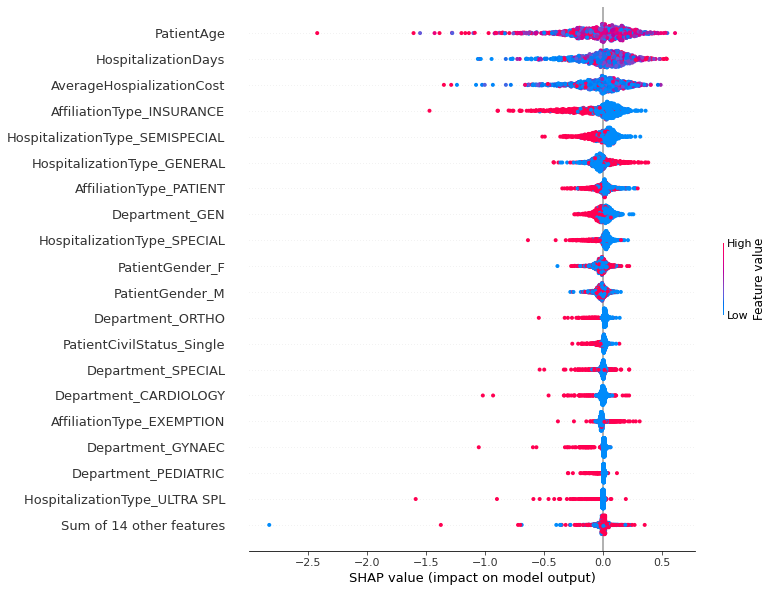

In [39]:
shap.plots.beeswarm(rf_segments_shap_values, plot_size=(10, 10), max_display=20)

In [40]:
# shap.summary_plot(shap_values, X_transformed, plot_size=(10,10), feature_names=preprocessor.get_feature_names_out())

In [41]:
df = training_data.groupby("Department AffiliationType HospitalizationType".split())["LTR"].agg("mean std count".split()).sort_values(by="mean")

In [53]:
training_data.shape

(4989, 52)

In [52]:
training_data["LTR"].mean()

8.514131088394468

In [42]:
df[df["count"] > 50]

mean       std  count
Department AffiliationType HospitalizationType                           
GEN        INSURANCE       SEMISPECIAL          8.116631  1.871235    463
PEDIATRIC  INSURANCE       SPECIAL              8.231707  1.399284     82
GYNAEC     EXEMPTION       SEMISPECIAL          8.236364  1.666263     55
GEN        INSURANCE       SPECIAL              8.269388  1.810964    245
PEDIATRIC  INSURANCE       SEMISPECIAL          8.310345  1.551514    116
           PATIENT         SEMISPECIAL          8.322581  1.690061    155
GYNAEC     INSURANCE       SEMISPECIAL          8.372549  1.509447     51
GEN        PATIENT         SPECIAL              8.383562  1.843012    146
                           SEMISPECIAL          8.392749  1.808182    331
           INSURANCE       GENERAL              8.432927  1.527382    164
SPECIAL    INSURANCE       SEMISPECIAL          8.468468  1.925049    111
ORTHO      INSURANCE       SEMISPECIAL          8.484848  1.315498     66
SPECIAL    PATIENT         SEMISPECIAL          8.500000  1.535832    132
                           SPECIAL              8.523077  2.008635     65
GEN        PATIENT         ULTRA SPL            8.538462  2.062376     52
           CORPORATE       SEMISPECIAL          8.602273  1.579610     88
GYNAEC     EXEMPTION       SPECIAL              8.634615  1.283819     52
GEN        PATIENT         GENERAL              8.642680  1.524710    403
SPECIAL    INSURANCE       SPECIAL              8.673077  1.617565     52
PEDIATRIC  PATIENT         GENERAL              8.710526  1.030415     76
GEN        INSURANCE       ULTRA SPL            8.725806  1.189701     62
SPECIAL    PATIENT         GENERAL              8.726027  1.416750    146
GEN        CORPORATE       GENERAL              8.736842  1.619617     76
ORTHO      PATIENT         GENERAL              8.746988  1.480305     83
SPECIAL    EXEMPTION       SEMISPECIAL          8.847222  1.641536     72
CARDIOLOGY EXEMPTION       SEMISPECIAL          9.071429  1.396906     70
                           GENERAL              9.132353  1.735532     68